# On Galerkin approximations for the QG equations
## Supplementary material for subsection on the $\beta-$Eady model 
<p></p> 
### Cesar B. Rocha*, William R. Young, and Ian Grooms 
<p></p> 
### Winter 2015
<p></p> 
*Scripps Institution of Oceanography, University of California, San Diego, 9500 Gilman Dr. MC 0213, La Jolla, CA/USA, <crocha@ucsd.edu>   

## The $\beta-$Eady problem

Adding a non-zero background planetary vorticity gradient ($\beta$) significantly changes the linear stability analysis for approximations B and C. The interior equations are no longer trivially satisfied, so we have to solve $(\mathrm{N}+3)\times(\mathrm{N}+3)$ eigenvalue problems. Approximation A still leads to a $(\mathrm{N}+1)\times(\mathrm{N}+1)$ eigenvalue problem. 

This notebook builds previous code developed for the <a href="http://nbviewer.ipython.org/github/crocha700/qg_vertical_modes/blob/master/eady_problem/linear_eady_galerk.ipynb">Eady problem</a>. In fact, we will be able to recover the Eady problem when $\beta = 0$.

In [26]:
from __future__ import division
import numpy as np
import scipy as sp
import scipy.linalg 

try:
    import mkl
    np.use_fastnumpy = True
except ImportError:
    pass

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 30, 'legend.handlelength'  : 1.25})

In [2]:
import numba
from numpy import pi,cos,sqrt,sinh,cosh

def cn(kappa,n):
    ''' n-th mode non-dimensional
        Rossby wave phase speed '''
    return -1./(kappa**2 + (n*pi)**2)

# nopython=True means an error will be raised
# if fast compilation is not possible.
def sigma12(kappa,Nmax):
    ''' evaluate sigma1 and sigma2
        sums for used in methods B and C 
        Nmax is the number of baroclinic modes '''
    
    i = np.arange(Nmax+1)
    c = cn(kappa,i)
    assert i[-1] == Nmax, 'Error in forming sums'
    sigma1 = c[0] + 2.*c[1:].sum()        
    sigma2 = c[0] + 2.*(( (-1.)**i[1:] )*c[1:]).sum()
    
    return sigma1,sigma2

@numba.jit(nopython=True)
def UGpm(Nmax):
    ''' evaluate series for base velocity
        at the boundaries 
        Nmax is the number of baroclinic modes'''

    up,um = .5,.5
    for i in range(1,Nmax+1,2):
        up +=  4./( (i*pi)**2 )
        um += -4./( (i*pi)**2 )

    return up,um

@numba.jit(nopython=True)
def Xi(k,m,n):
    ''' the interaction coefficient 
        Xi for constant stratification '''

    if  ((k==0) and (m==n)): x = 1.
    elif ((m==0) and (k==n)): x = 1.
    elif ((n==0) and (k==m)): x = 1.    
    elif ((k == m+n) or (k == m-n) or (k == n-m)): 
        x = sqrt(2)/2.
    else: x = 0.

    return x

### The stability matrix

In [3]:
def stability_matrix(kappa,Nmax,method='A',beta=1.,nu=0.):
    ''' Linear stability matrix for
        Eady Problem using method A

            M phi = c phi, where c
            are the eigenvalues and phi
            the eigenvector         
            
            M is a Nmax+1 by Nmax+1 matrix
            
            Nmax is the number of baroclinic modes
                for the solution
  '''

    if method == 'A':

        # n+1 by n+1 problem
        M1 = np.zeros((Nmax+1,Nmax+1))  
        M2 = np.zeros((Nmax+1,Nmax+1))
        D = np.zeros((Nmax+1,Nmax+1))

        # loop over rows    
        for k in range(Nmax+1):
    
            # M1 
            for m in range(Nmax+1):
                for n in range(1,Nmax+1,2):
                    gamma = -2.*sqrt(2)/( kappa**2 + (m*pi)**2 )    
                    M1[k,m] += Xi(k,n,m)*gamma

            # M2
            for n in range(Nmax+1):
                for m in np.append(0,range(1,Nmax+1,2)):
                    if m == 0:
                        U = 1/2.
                    else:    
                        U = 2.*sqrt(2)/( (m*pi)**2 )
                    M2[k,n] += Xi(k,n,m)*U

            # beta term and horizontal diffusivity
            D[k,k] = beta*cn(kappa,k) + 1.e-3*(kappa**2)

        M = M1 + M2 + D

    elif method == 'B':

        # n+3 by n+3 problem
        M2 = np.zeros((Nmax+3,Nmax+3)) + 0j
        D = np.zeros((Nmax+3,Nmax+3))  + 0j
        S = np.zeros((Nmax+3,Nmax+3))  + 0j
    
        cosech_k = 1./sinh(kappa)
        coth_k = cosh(kappa)/sinh(kappa)

        taup,taum = coth_k/kappa, cosech_k/kappa
        sigp,sigm = -cosech_k/kappa, -coth_k/kappa

        sig1,sig2 = sigma12(kappa,Nmax)
        up,um = UGpm(Nmax)

        # loop over rows    
        for kk in range(0,Nmax+3):

            if kk == 0:
                
                S[0,0] += 1. - taup
                S[0,-1] += - sigp

                for mm in range(1,Nmax+2):
                    m = mm -1
                    if m == 0:
                        S[0,mm] = -cn(kappa,m)
                    else:
                        S[0,mm] = -sqrt(2)*cn(kappa,m)

            elif kk == Nmax+2:
                
                S[-1,0] += - taum
                S[-1,-1] += 0. - sigm
                
                for mm in range(1,Nmax+2):
                    m = mm -1
                    if m == 0:
                        S[-1,mm] = -cn(kappa,m)
                    else:
                        S[-1,mm] = -sqrt(2)*((-1)**m)*cn(kappa,m)

            else:

                k = kk-1 # use k to keep same indexing as in the Eady

                # M2
                for ss in range(1,Nmax+2):
                    
                    s = ss -1

                    if k == s:
                        M2[kk,ss] += 0.5

                    elif (k == 0) and (s%2):
                            M2[kk,ss] += 2*sqrt(2)/( (s*pi)**2 )
                    elif (s == 0) and (k%2):
                            M2[kk,ss] += 2*sqrt(2)/( (k*pi)**2 )
                    elif (k+s)%2:
                            M2[kk,ss] += 4.*(k**2 + s**2) / ( ((k**2 - s**2)*pi)**2 )


                # beta term and horizontal diffusivity
                D[kk,kk] = beta*cn(kappa,k) - 1j*nu*(kappa)
                if k == 0:
                    D[kk,0] = -beta*cn(kappa,k)
                    D[kk,-1] = beta*cn(kappa,k)
                else:
                    D[kk,0] = -sqrt(2)*beta*cn(kappa,k)
                    D[kk,-1] = sqrt(2)*beta*( (-1)**k )*cn(kappa,k) 


        M = S  + D + M2

    elif method == 'C':

        # n+3 by n+3 problem
        M1 = np.zeros((Nmax+3,Nmax+3)) + 0j 
        M2 = np.zeros((Nmax+3,Nmax+3)) + 0j
        D = np.zeros((Nmax+3,Nmax+3))  + 0j
        S = np.zeros((Nmax+3,Nmax+3))  + 0j

        sig1,sig2 = sigma12(kappa,Nmax)
        up,um = UGpm(Nmax)

        # loop over rows    
        for kk in range(0,Nmax+3):

            if kk == 0:
                S[0,0] = up + sig1
                S[0,-1] = -sig2
                for mm in range(1,Nmax+2):
                    m = mm -1
                    if m == 0:
                        S[0,mm] = -cn(kappa,m)
                    else:
                        S[0,mm] = -sqrt(2)*cn(kappa,m)

            elif kk == Nmax+2:
                S[-1,-1] =  um - sig1
                S[-1,0]  = sig2
                for mm in range(1,Nmax+2):
                    m = mm -1
                    if m == 0:
                        S[-1,mm] = -cn(kappa,m)
                    else:
                        S[-1,mm] = -sqrt(2)*((-1)**m)*cn(kappa,m)

            else:

                k = kk-1 # use k to keep same indexing as in the Eady

                # M2
                for nn in range(1,Nmax+2):
                    n=nn-1
                    for m in np.append(0,range(1,Nmax+1,2)):
                        if m == 0:
                            U = 1/2.
                        else:    
                            U = 2.*sqrt(2)/( (m*pi)**2 )
                        M2[kk,nn] += Xi(k,n,m)*U


                # beta term and horizontal diffusivity
                D[kk,kk] = beta*cn(kappa,k) - 1j*nu*(kappa)
                if k == 0:
                    D[kk,0] = -beta*cn(kappa,k)
                    D[kk,-1] = beta*cn(kappa,k)
                else:
                    D[kk,0] = -sqrt(2)*beta*cn(kappa,k)
                    D[kk,-1] = sqrt(2)*beta*( (-1)**k )*cn(kappa,k)

        M = S + M2 + D

    return M

### The stability analysis for approximations A, B, C

In [4]:
def stability_analysis_galerk(kappa,Nmax,method='A',beta=1.,nu=0.,efunc=False):
    '''
     Compute the growth rate of the linear
     stability problem given an array of 
     wavenumbers kappa

        Nmax is the number of baroclinic modes
            for the solution


    '''

    try:
        Nkappa = kappa.size
        c = np.zeros(Nkappa,dtype='complex128')
        sig = np.zeros(Nkappa)
        if efunc:
            efun = np.zeros((Nmax+2,Nkappa),dtype='complex128') 

        for i in range(Nkappa):
            M = stability_matrix(kappa[i],Nmax,method,beta=beta,nu=nu)
            cm,em = np.linalg.eig(M)
            imax = cm.imag.argmax()
            c[i],sig[i] = cm[imax],kappa[i]*cm.imag[imax]
            if efunc:
                efun[:,i] = em[:,imax]

    except AttributeError:

        M = stability_matrix(kappa,Nmax,method,beta=beta,nu=nu)
        cm,em = np.linalg.eig(M)
        imax = cm.imag.argmax()
        c,sig = cm[imax],kappa*cm.imag[imax]
        if efunc:
            efun = em[:,imax]

    if efunc: return c,efun,sig
    else : return c,sig

In [1]:
# settings
kappa = np.linspace(0.001,30.,200)
Nmodes = np.arange(0,25)
Nmodes = np.append(Nmodes,2**np.arange(5,8))

# assemble arrays
c_galerkA,sig_galerkA = np.zeros((Nmodes.size,kappa.size),\
        dtype='complex128'),np.zeros((Nmodes.size,kappa.size))
c_galerkB,sig_galerkB = np.zeros((Nmodes.size,kappa.size),\
        dtype='complex128'),np.zeros((Nmodes.size,kappa.size))
c_galerkC,sig_galerkC = np.zeros((Nmodes.size,kappa.size),\
        dtype='complex128'),np.zeros((Nmodes.size,kappa.size))


# solve the linear problem
for i in range(Nmodes.size):
    c_galerkA[i,:],sig_galerkA[i,:] = stability_analysis_galerk(kappa,\
            Nmodes[i],method='A',beta=1.,nu=0.,efunc=False)
    c_galerkB[i,:],sig_galerkB[i,:] = stability_analysis_galerk(kappa,\
           Nmodes[i],method='B',beta=1.,nu=0.,efunc=False)   
    c_galerkC[i,:],sig_galerkC[i,:] = stability_analysis_galerk(kappa,\
           Nmodes[i],method='C',beta=1.,nu=0.,efunc=False)

NameError: name 'np' is not defined

It's useful to save the results

In [6]:
np.savez('outputs/beta-eady_A.npz',c=c_galerkA,sig=sig_galerkA,\
         kappa=kappa,Nmodes=Nmodes)
np.savez('outputs/beta-eady_B.npz',c=c_galerkB,sig=sig_galerkB,\
         kappa=kappa,Nmodes=Nmodes)
np.savez('outputs/beta-eady_C.npz',c=c_galerkC,sig=sig_galerkC,\
         kappa=kappa,Nmodes=Nmodes)

### The stability analysis using finite-differences approximation

It's convenient to create simple functions to compute differences matrices

In [33]:
def D2_matrix(N):
    ''' create an N x N second order differences matrix '''
    D2 = np.zeros((N,N))
    for i in range(N):
        D2[i,i] = -2.
        if i<N-1: D2[i,i+1] = 1.
        if i>0: D2[i,i-1] = 1.
    
    assert np.array_equal(D2-D2.T,np.zeros((N,N))), 'Matrix not symmetric'
    
    return D2

It's easier to formulate the problem in terms of streamfunction $\phi$. A second order finite-differences (using ghost points at the boundaries) leads to a generalized eigenvalue problem

\begin{equation}
\mathsf{A}\,\mathsf{\phi} = c\, \mathsf{B}\,\mathsf{\phi}
\end{equation}

We now assemble the matrices $\mathsf{A}$ and $\mathsf{B}$.

In [31]:
def CharneyMatrix(kappa,N,beta=1.0,nu=.0):
    ''' Creates matrices for Charney linear problem
            using second-order finite differences
            scheme 

            - kappa: wavenumber 
            - N: number of vertical levels '''

    dz = 1./N   # vertical resolution
    z = np.arange(-dz/2,-1.-dz/2.,-dz)  # level array
    u  = 1. + z

    Ut,Ub = 1.,0. # top and bottom vel.
    
    #
    #   first and second elements of the eigenvector
    #       are ghost points

    D2 = D2_matrix(N+2)/(dz**2)
    A = np.zeros((N+2,N+2))
    B = np.zeros((N+2,N+2))
      
    # assemble matrices
    for i in range(1,N+1):
        A[i,:] = u[i-1]*D2[i,:]
        A[i,i] += beta - u[i-1]*(kappa**2)

        B[i,:] = D2[i,:]
        B[i,i] -= kappa**2

    # add submesoscale horizontal diffusivity (nu)
    A[1:N+1,1:N+1] += D2[1:N+1,1:N+1]*nu*(kappa**2) - nu*(kappa**4)*np.eye(N,N)

    # top
    A[0,0],A[0,1] = Ut/dz -.5, -(Ut/dz +.5)
    B[0,0],B[0,1] = 1./dz, -1./dz

    # bottom
    A[-1,-2],A[-1,-1] = Ub/dz -.5, -(Ub/dz+.5)
    B[-1,-2],B[-1,-1] = 1./dz,-1./dz

    return A,B

We now solve the stability problem

In [29]:
def stability_analysis_num(kappa,N,beta=1.,nu=0.,nmodes=1):
    '''
     Compute the growth rate of the linear
     stability problem given an array of 
     wavenumbers kappa

        N is the of vertical levels '''

    try:
        Nkappa = kappa.size
        c = np.zeros(Nkappa,dtype='complex128')
        c2 = np.zeros(Nkappa,dtype='complex128')
        sig = np.zeros(Nkappa)
        sig2 = np.zeros(Nkappa)
        efun = np.zeros((N+2,Nkappa)) + 0j
        efun2 = np.zeros((N+2,Nkappa)) + 0j

        for i in range(Nkappa):
            M1,M2 = CharneyMatrix(kappa[i],N,beta,nu)
            cm,em = sp.linalg.eig(M1,M2)
            isort = cm.imag.argsort()
            c[i],sig[i] = cm[isort[-1]],kappa[i]*cm.imag[isort[-1]]
            efun[:,i] = em[:,isort[-1]]
            if nmodes == 2:
                c2[i],sig2[i] = cm[isort[-2]],kappa[i]*cm.imag[isort[-2]]
                efun2[:,i] = em[:,isort[-2]]

    except AttributeError:

        M1,M2 = CharneyMatrix(kappa,N,beta,nu)
        cm,em = sp.linalg.eig(M1,M2)
        isort = cm.imag.argsort()        
        c,sig = cm[isort[-1]],kappa*cm.imag[isort[-1]]
        efun = em[:,isort[-1]]

        if nmodes == 2:
            c2,sig2 = cm[isort[-2]],kappa[i]*cm.imag[isort[-2]]
            efun2 = em[:,isort[-2]]

    if nmodes == 2:
        return c,efun,sig,c2,efun2,sig2
    else:
        return c,efun,sig

In [ ]:
# parameters
N = 1000     
kappa = np.linspace(0.001,10.,100)
beta = 1.

c_num,e_num,sig_num = stability_analysis_num(kappa,N,beta=beta,nu=0,nmodes=1)

In [14]:
np.savez('outputs/beta-eady_num.npz',kappa=kappa,c=c_num,sig=sig_num,e=e_num,N=N)

Now we plot the results

In [6]:
#import seaborn as sns
#sns.set(style="darkgrid")
#sns.set_context("paper", font_scale=5., rc={"lines.linewidth": 1.5})
#sns.set_style("darkgrid",{'grid_color':.95})

def labels(field='sig',fs=50):
    plt.xlabel(r'$\kappa \times\, L_d$',fontsize=fs)
    if field == 'sig':    
        plt.ylabel(r'$\sigma \times \, \frac{\Lambda H}{L}$',fontsize=fs)
    elif field == 'ps':
        plt.ylabel(r'$c_r / \Lambda H$',fontsize=fs)

def plt_exact(field='sig'):
    if field == 'sig':
        plt.plot(lcharneyNum['kappa'],lcharneyNum['sig'],color="k",\
                linewidth=4.,label='Finite Differences')
    elif field == 'ps':
        plt.plot(lcharneyNum['kappa'],lcharneyNum['c'].real,color="k",\
                linewidth=4.,label='Finite Differences')


In [7]:
data_path = 'outputs/beta-eady_'
data_pathA, data_pathB,data_pathC = "linear_charney_A.npz","linear_charney_B.npz","linear_charney_C.npz"
data_pathNum = "linear_charney_num.npz"

lcharneyA = np.load(data_path+'A'+'.npz')
lcharneyB = np.load(data_path+'B'+'.npz')
lcharneyC = np.load(data_path+'C'+'.npz')
lcharneyNum = np.load(data_path+'num'+'.npz')

# plot settings
lw,aph = 4.,.75
Nmodes = lcharneyC['Nmodes']
color1,color2,color3 = "#1e90ff","#ff6347","#32cd32"

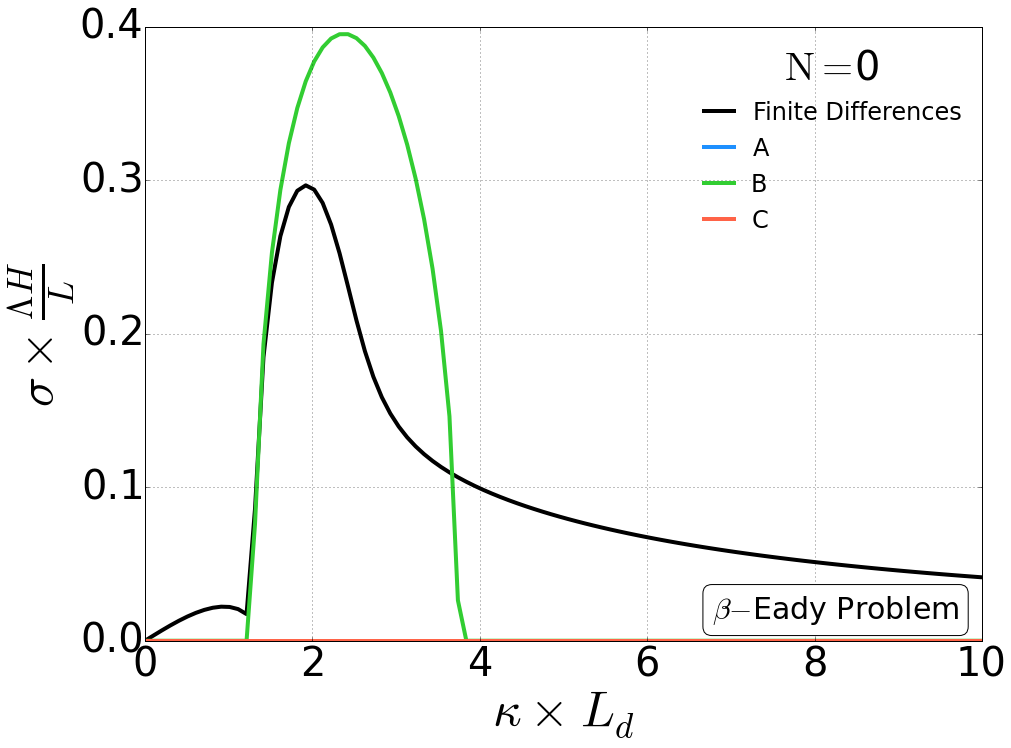

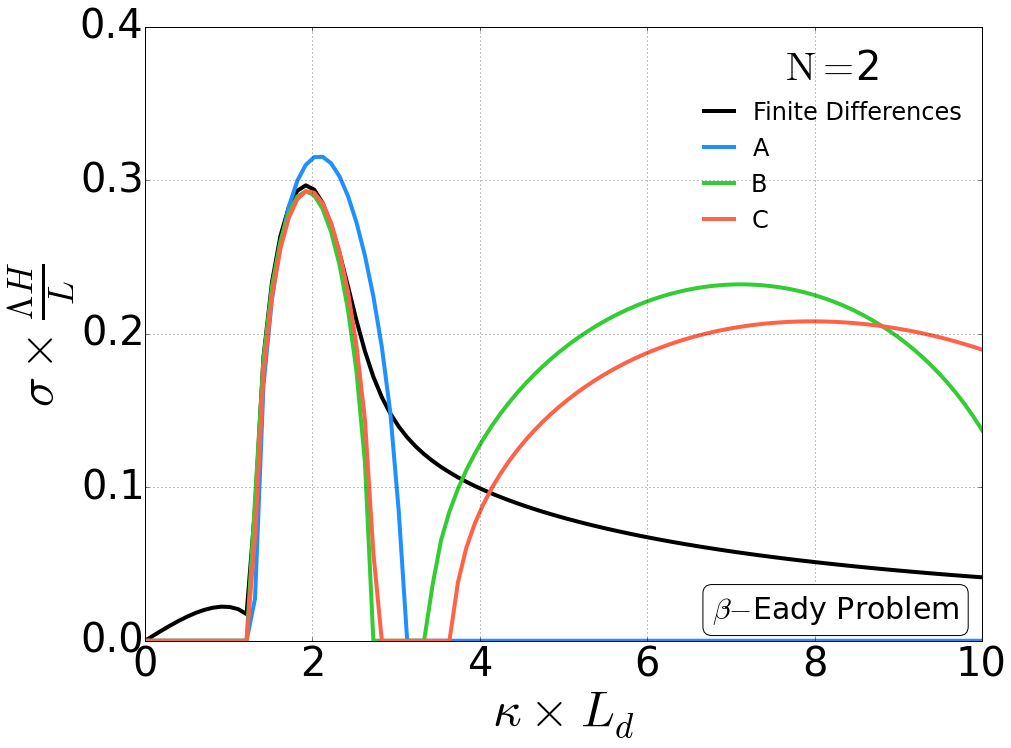

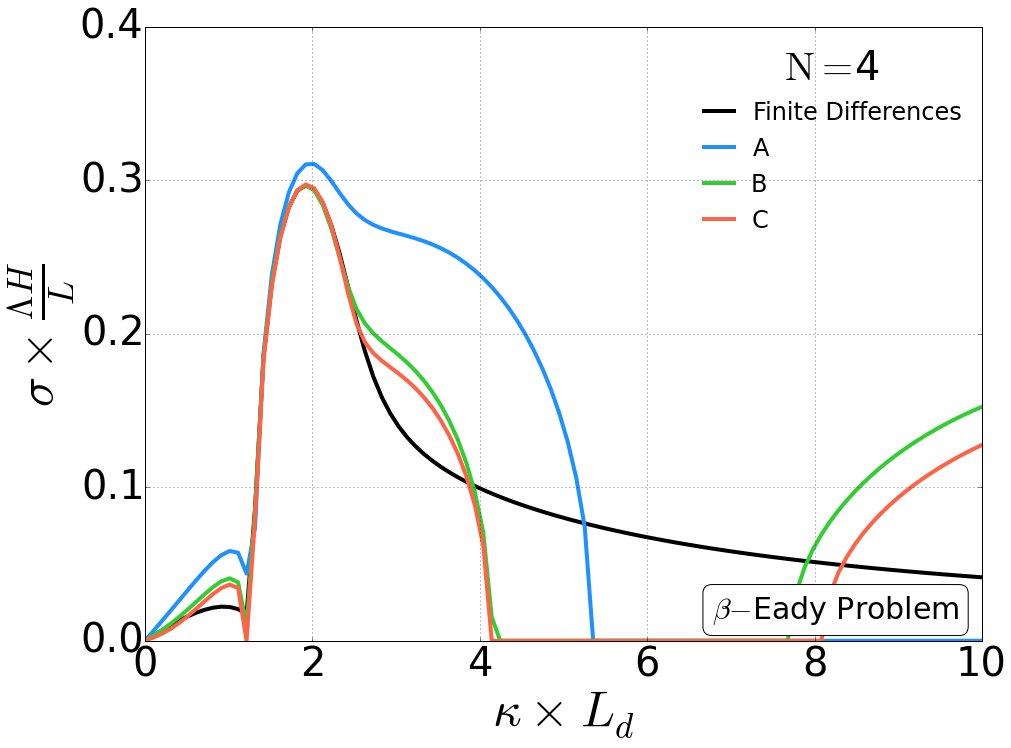

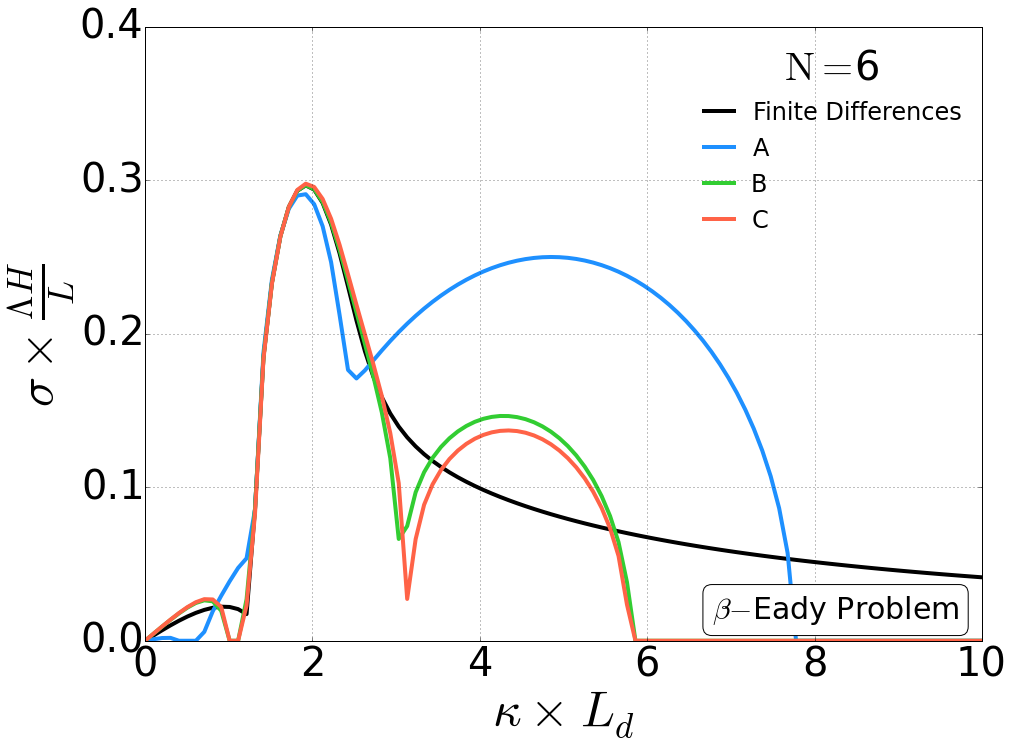

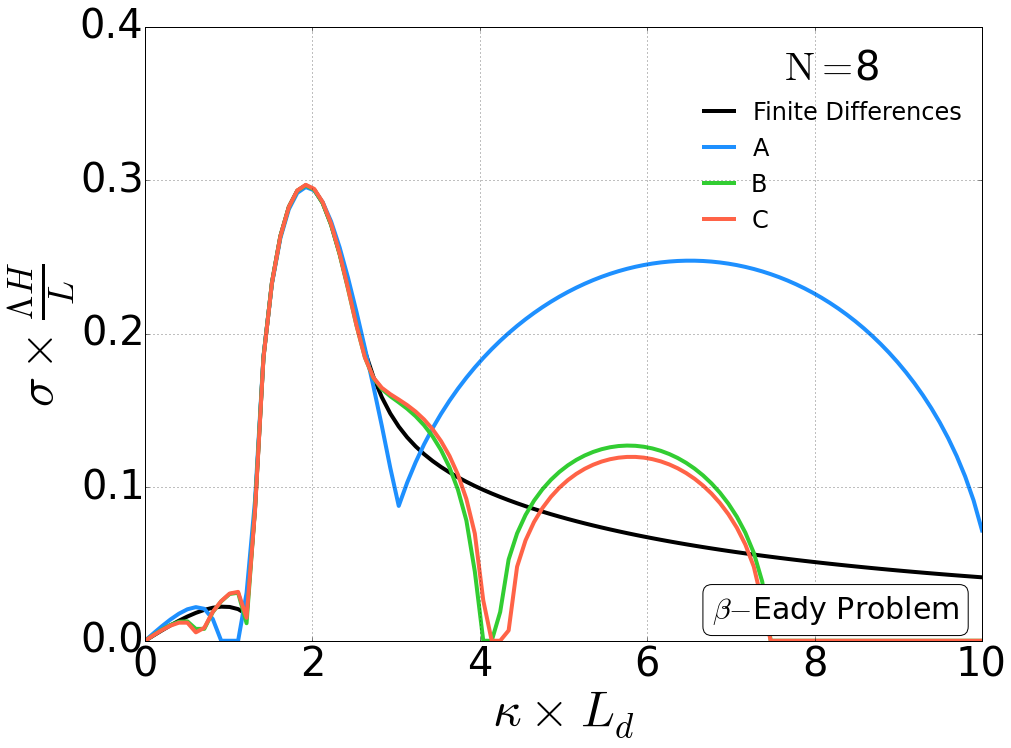

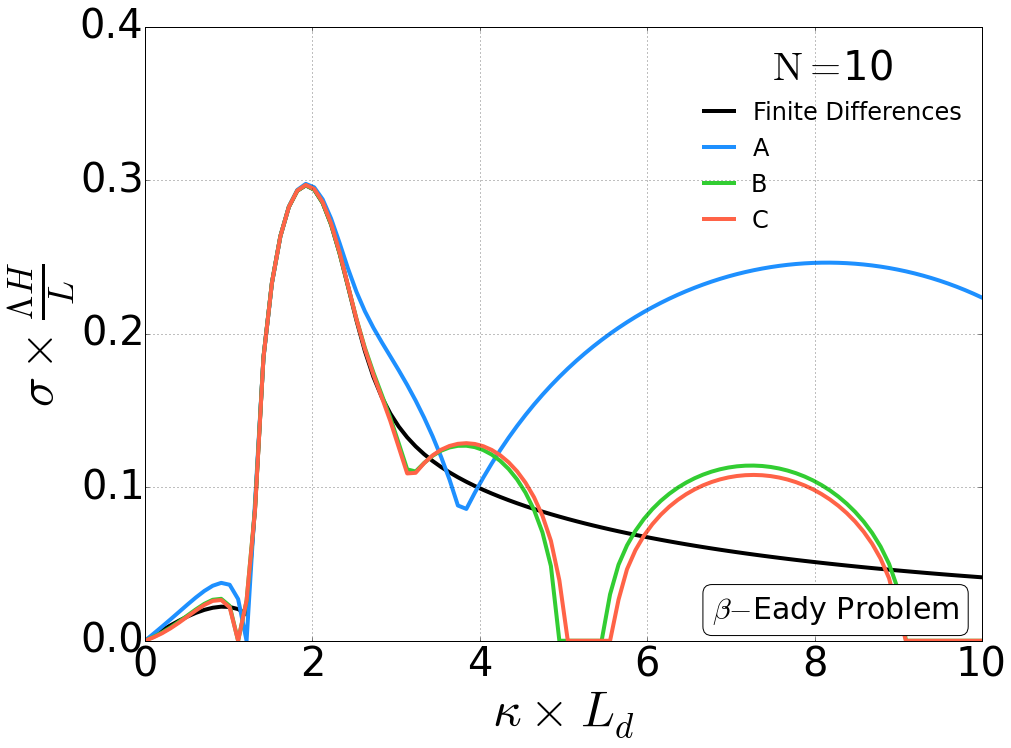

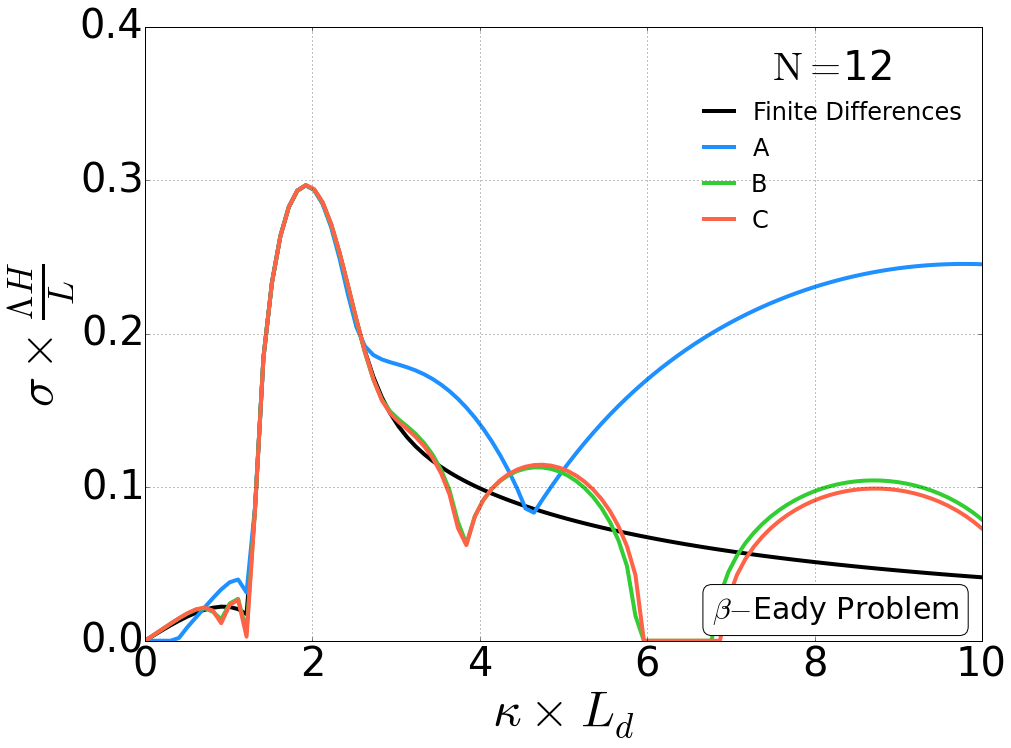

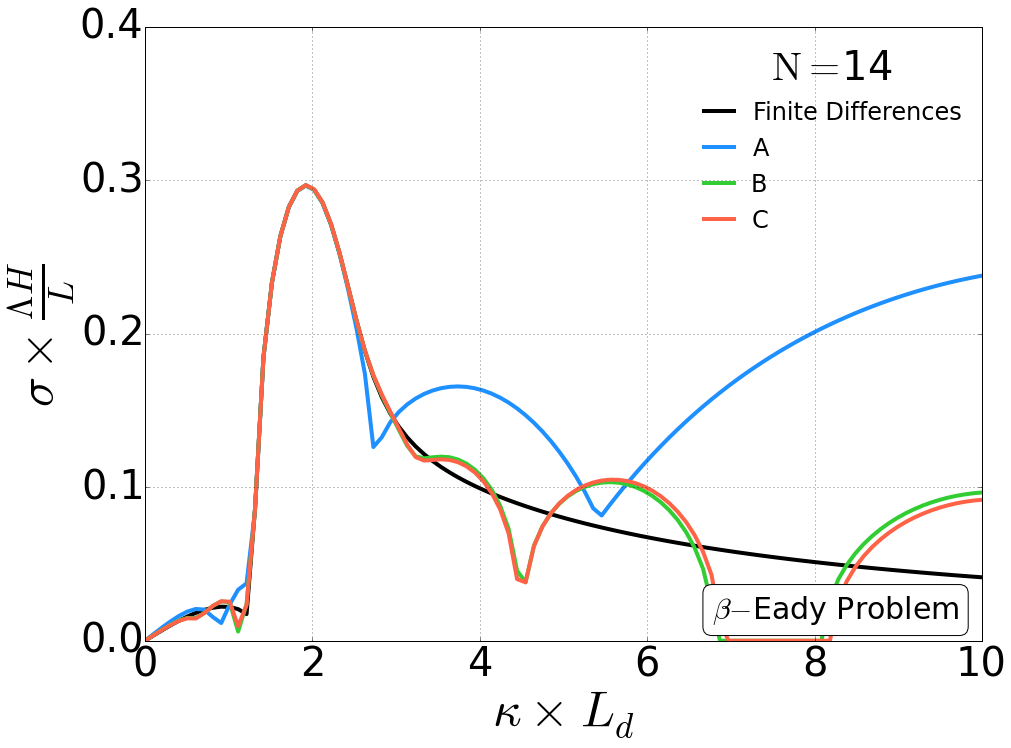

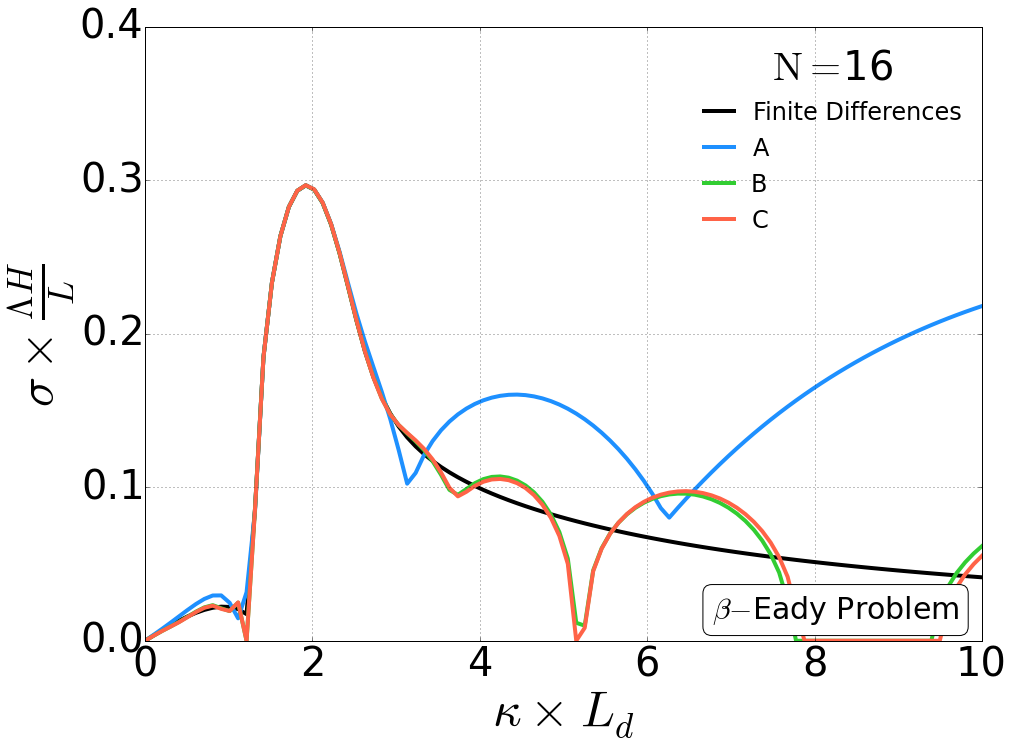

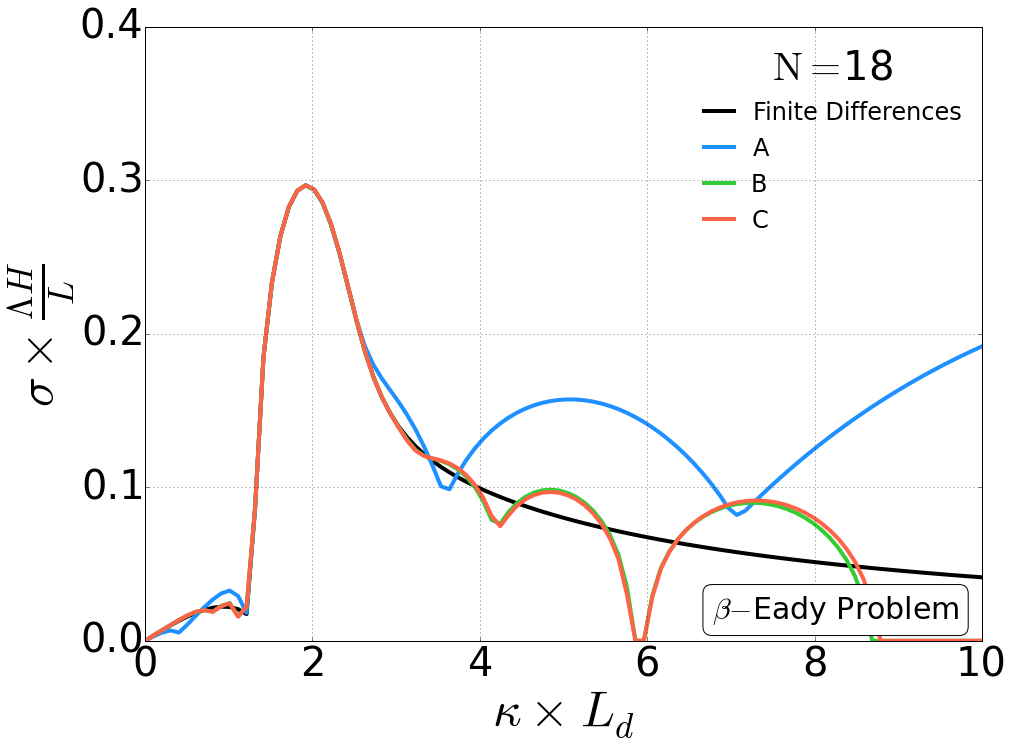

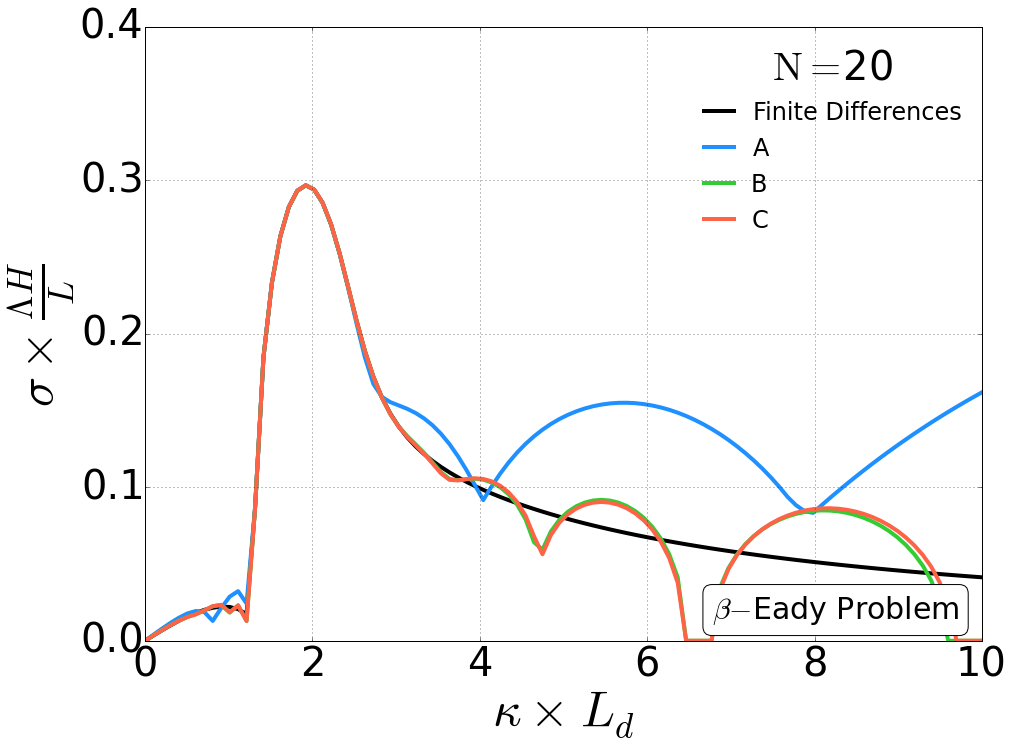

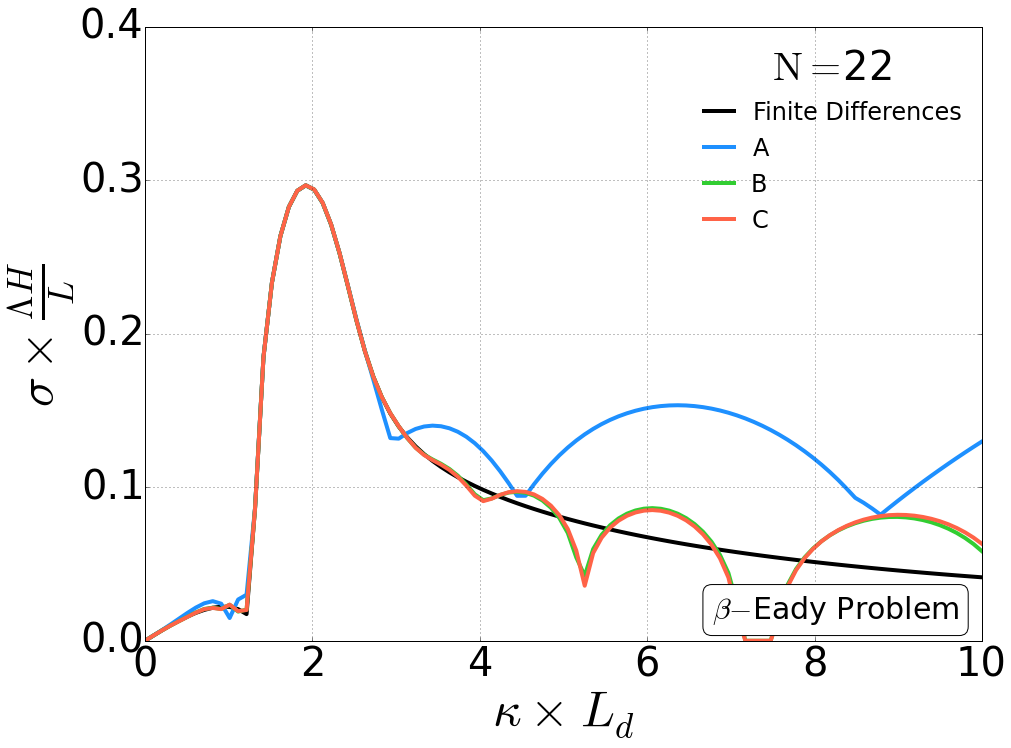

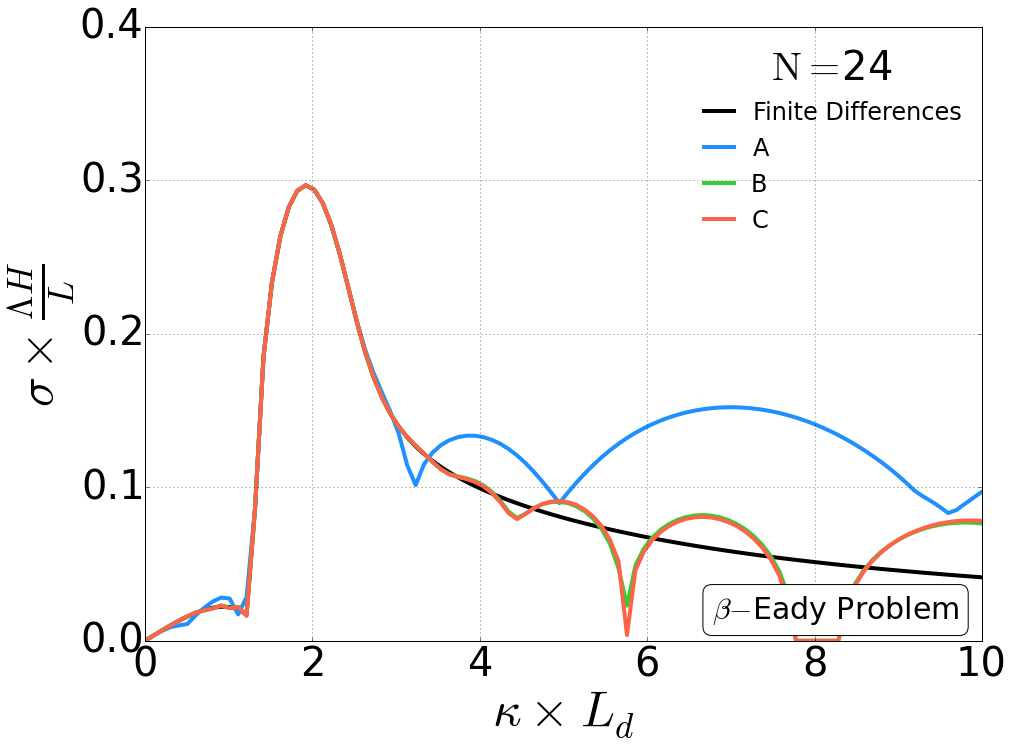

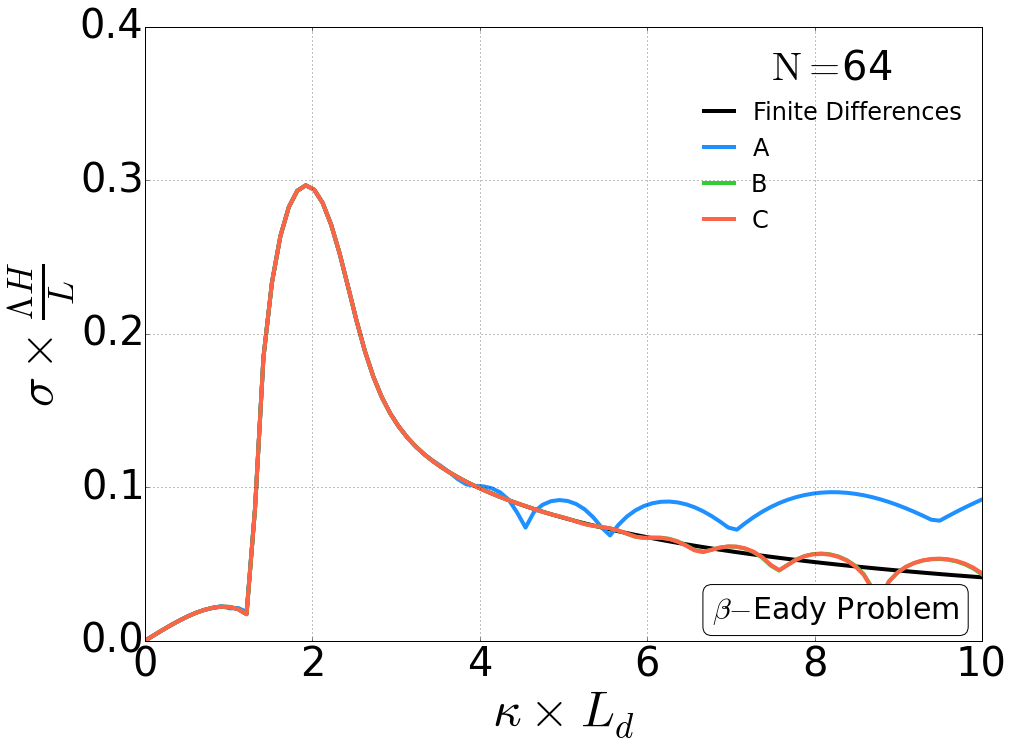

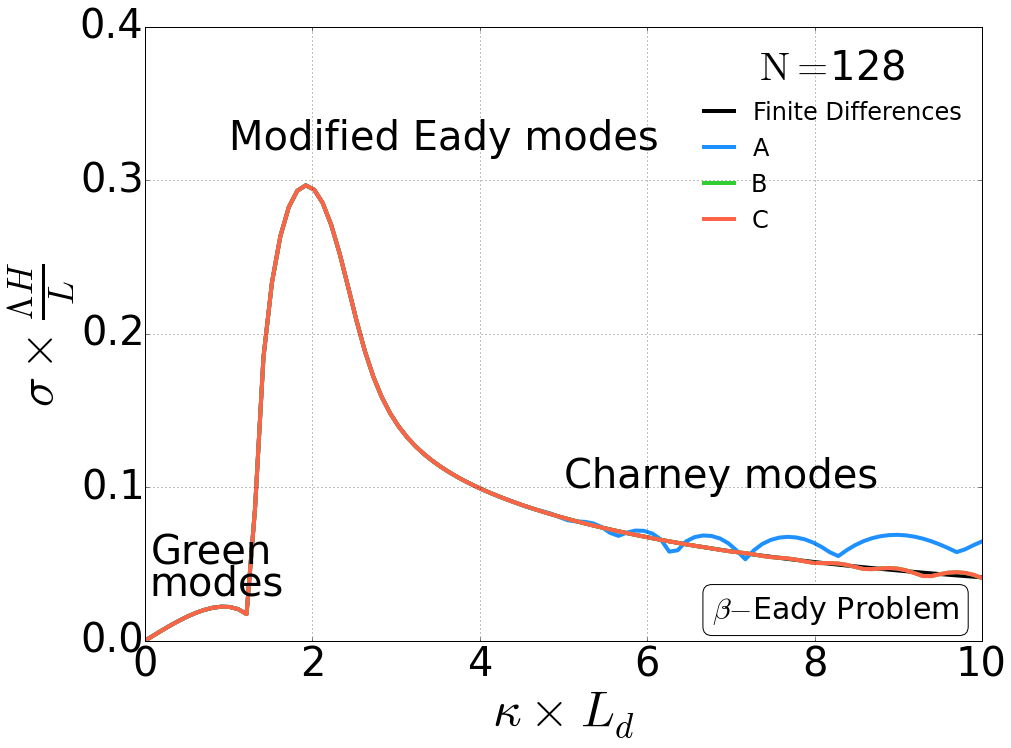

In [19]:
# individual modes
for i in range(Nmodes.size):
    fig=plt.figure(figsize=(15,11))
    plt_exact('sig')
    plt.plot(lcharneyA['kappa'],lcharneyA['sig'][i,:],\
                color=color1,linewidth=lw,label='A')
    plt.plot(lcharneyB['kappa'],lcharneyB['sig'][i,:],\
                color=color3,linewidth=lw,label='B')
    plt.plot(lcharneyC['kappa'],lcharneyC['sig'][i,:],\
                color=color2,linewidth=lw,label='C')

    plt.grid()
    labels() 
    plt.yticks(np.arange(0.,.5,.1))
    plt.legend(loc=1, title = r'$\mathrm{N} = $' + str(Nmodes[i]))
    plt.ylim(0.,0.4)
    plt.xlim(0,10)
    
    # annotate order of the figure (for publication)
    pm = True
    nm = Nmodes[i]

    plt.tick_params(axis='both', which='major', labelsize=40)
    
    plt.text(8.25, .02, r"$\beta-$Eady Problem", size=30, rotation=0.,\
                ha="center", va="center",\
                bbox = dict(boxstyle="round",ec='k',fc='w'))

    figtit = 'figs/beta-eady_sig_galerk_ABC_'+str(Nmodes[i])+'.eps'
    plt.savefig(figtit,format='eps') 

    if i < Nmodes.size-1:
        if i%2: 
            plt.close()
    else:
        plt.text(.1,.05,'Green')
        plt.text(.1,.03,'modes')
        plt.text(1.,.32,'Modified Eady modes')
        plt.text(5.,.1,'Charney modes')
        figtit = 'figs/beta-eady_sig_galerk_ABC_'+str(Nmodes[i])+'.eps'
        plt.savefig(figtit,format='eps', bbox_inches = 'tight')

# Convergence rate

In [21]:
#relative_error(exact,approx)
def find_nearest(x, x0):
    "find closest to x0 in array value"
    idx = np.abs(x - x0).argmin()
    return x[idx],idx

def absolute_error(exact,approx):
    ''' compute absolute error '''
    return np.abs(exact-approx)

In [22]:
# the fasted growing mode
imax = lcharneyNum['sig'].argmax()

# calculate error at some wanumbers
kappas = np.array([.5,kappa[imax],4.,8.])
inds = np.zeros(kappas.size)

for i in range(kappas.size):    
    kappas[i],inds[i] = find_nearest(kappa, kappas[i])

Now compute the error

In [23]:
errorA = np.zeros((Nmodes.size,kappas.size))
errorB = np.zeros((Nmodes.size,kappas.size))
errorC = np.zeros((Nmodes.size,kappas.size))

for n in range(Nmodes.size):
    for k in range(inds.size):
        errorA[n,k] = absolute_error(lcharneyNum['sig'][inds[k]],\
                                     lcharneyA['sig'][n,inds[k]])
        errorB[n,k] = absolute_error(lcharneyNum['sig'][inds[k]],\
                                     lcharneyB['sig'][n,inds[k]])       
        errorC[n,k] = absolute_error(lcharneyNum['sig'][inds[k]],\
                                     lcharneyC['sig'][n,inds[k]]) 

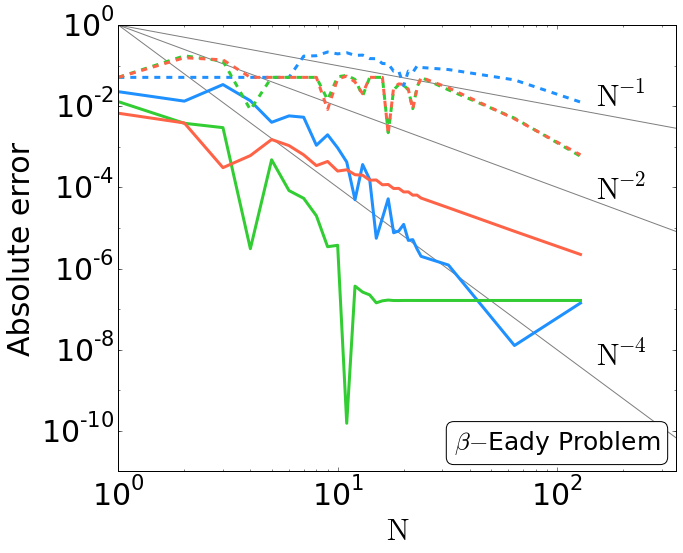

In [27]:
ns = np.array([1,500.])
lw = 3.

plt.figure(figsize=(10,8))

plt.loglog(ns,1/ns**2,'k',alpha=.5)
plt.loglog(ns,1/ns**1,'k',alpha=.5)
plt.loglog(ns,1/ns**4,'k',alpha=.5)

# solid line error at k ~2 (max growth rate)
plt.loglog(Nmodes,errorA[:,1],color=color1,label='A',linewidth=lw)
plt.loglog(Nmodes,errorB[:,1],color=color3,label='B',linewidth=lw)
plt.loglog(Nmodes,errorC[:,1],color=color2,label='C',linewidth=lw)
# dashed line error at k ~8 (max growth rate)
plt.loglog(Nmodes,errorA[:,-1],'--',color=color1,linewidth=lw)
plt.loglog(Nmodes,errorB[:,-1],'--',color=color3,linewidth=lw)
plt.loglog(Nmodes,errorC[:,-1],'--',color=color2,linewidth=lw)
plt.yticks(np.array([1.e-10,1.e-8,1.e-6,1.e-4,1.e-2,1.e0]))
plt.tick_params(axis='both', which='major', labelsize=30)    
plt.text(150,4.e-9,r'$\mathrm{N}^{-4}$')
plt.text(150,5.e-5,r'$\mathrm{N}^{-2}$')
plt.text(150,1.e-2,r'$\mathrm{N}^{-1}$')
plt.xlabel(r"$\mathrm{N}$",fontsize=30)
plt.ylabel(r"Absolute error",fontsize=30)
plt.xlim(0,350)
plt.text(100, .5e-10, r"$\beta-$Eady Problem", size=25, rotation=0.,\
                ha="center", va="center",\
                bbox = dict(boxstyle="round",ec='k',fc='w'))
plt.savefig('figs/Error_beta_eady.eps',format='eps')

As sanity a test for our code, we compare the function stability curve from **stability_analysis** with $\mathrm{N}=0$ with the simplest model. First, we construct the basic state, which should be a steady solution to the non-linear equations for approximation B. In particular we choose a solution independent of $x$. A possiblity, consistent with Eady's basic state, is
<p></p>
\begin{equation}
\Sigma = -y\left(z+1\right) \qquad \text{and} \qquad Q_0 = \Phi_0 = 0\,.
\end{equation}
Hence

\begin{equation}
T_0 = \int_{-1}^{0} \Sigma \,d z = -\frac{y}{2}\, .
\end{equation}
<p></p>
Notice that
\begin{equation}
\Delta T_0 = 0 \longrightarrow \Theta^{+} = \Theta^{-} = \Theta\, .
\end{equation}
Matching the shear at the boundaries we obtain $\Theta = -y$.
<p></p>
The linearized interior equation is 

\begin{equation}
\partial_t q_0 -\partial_y \,T_0\,\partial_x\,q_0 + \hat{\beta}\, \partial_x \left(\phi_0 + \tau_0\right) = 0\, .
\end{equation}
<p></p>
The boundary conditions are
\begin{equation}
\partial_t \vartheta^{\pm} - \partial_y\,\Theta\,\partial_x\,\phi_0 - \Sigma_y^{\pm} \partial_x \vartheta^{\pm} = 0\, .
\end{equation}
<p></p>
Fourier transforming, and using the inversion relationships 
<p></p>

\begin{equation}
\Delta \phi_0 = q_0 \qquad \text{and} \qquad \Delta \tau_0 = -\left(\vartheta^{+}-\vartheta^{-}\right)
\end{equation}
<p></p>
We obtain the eigenvalue problem
<p></p>
\begin{equation}
\begin{bmatrix}
1 - \frac{\coth{\kappa}}{\kappa} \qquad \frac{1}{\kappa^2}  \qquad\:\: \frac{\text{csech}\,\kappa}{\kappa}\\
\:\:\:\:\:\frac{\hat{\beta}}{\kappa^2} \qquad \frac{1}{2}-\frac{\hat{\beta}}{\kappa^2} \qquad -\frac{\hat{\beta}}{\kappa^2}\\
-\frac{\text{csech}\,\kappa}{\kappa}  \qquad \frac{1}{\kappa^2}  \qquad \frac{\coth{\kappa}}{\kappa}
\end{bmatrix}
\begin{bmatrix}
\hat{\vartheta}^{+}\\
\hat{{q}_0}\\
\hat{\vartheta}^{-}
\end{bmatrix}
=
c\, 
\begin{bmatrix}
\hat{\vartheta}^{+}\\
\hat{{q}_0}\\
\hat{\vartheta}^{-}
\end{bmatrix}
\end{equation}


<p></p>
This matrix is much easier to code than the general case, and therefore provide a simple sanity check on our previous code.

In [58]:
def matrixB_simplest(kappa,beta=1.):
    M = np.zeros((3,3))
    
    cosech_k = 1./sinh(kappa)
    coth_k = cosh(kappa)/sinh(kappa)

    M[0,0],M[0,1],M[0,2] = 1.-coth_k/kappa,1./kappa**2,cosech_k/kappa
    M[1,0],M[1,1],M[1,2] = beta/kappa**2,-beta/kappa**2+0.5,-beta/kappa**2
    M[2,0],M[2,1],M[2,2] = -cosech_k/kappa,1./kappa**2,coth_k/kappa

    return M    

def stability_simplest(kappa,beta=1.,debug=False):
    
    try:
        Nk = kappa.size
    except AttributeError:
        Nk = 1
        
    if Nk>1:
        c,sig = np.zeros(Nk)+0j, np.zeros(Nk)
        e = np.zeros((3,Nk),dtype='complex128')
        
        for i in range(Nk):
            M = matrixB_simplest(kappa[i],beta)
            
            cm,em = np.linalg.eig(M)
            
            assert ((3/2. - 1/kappa[i]**2) - (cm.real.sum()))<1.e-14,\
                "Sum of eigenvalue does not match the trace of the matrix"
            
            isort = cm.imag.argsort()
            c[i],sig[i] = cm[isort[-1]],kappa[i]*cm.imag[isort[-1]]
            e[:,i] = em[:,isort[-1]]          
             
            if debug: 
                if i == 0: 
                    print "The eigenvalues are"
                    print " "        
                print cm
        
        
    else: 
        M = matrixB_simplest(kappa,beta)
        cm,em = np.linalg.eig(M)
        
        assert ((3/2. - 1/kappa**2) - (cm.real.sum()))<1.e-14,\
                "Sum of eigenvalue does not match the trace of the matrix"
                
        isort = cm.imag.argsort()
        c,sig = cm[isort[-1]],kappa*cm.imag[isort[-1]]
        e = em[:,isort[-1]]
            
    return c,e,sig

In [71]:
kappa = np.linspace(0.001,10,100)
c_simplest,e_simples,sig_simplest = stability_simplest(kappa,beta=1.,debug=False)
c_galerkB0,sig_galerkB0 = stability_analysis_galerk(kappa,0,method='B',\
                                                    beta=1.,nu=0.0,efunc=False) 

We compare the two stability diagrams to make sure our code is not bogus

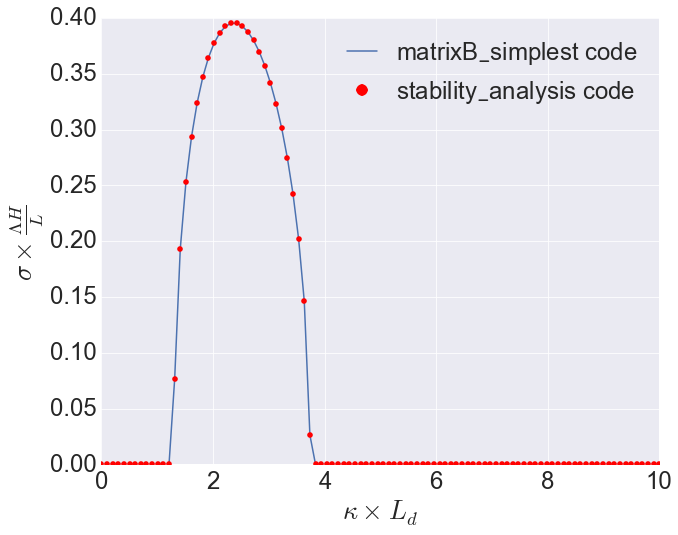

In [64]:
plt.figure(figsize=(10,8))

plt.plot(kappa,sig_simplest,label=r'matrixB$\_$simplest code')
plt.plot(kappa,sig_galerkB0,'ro',label=r'stability$\_$analysis code')
plt.xlabel(r'$\kappa \times\, L_d$')    
plt.ylabel(r'$\sigma \times \, \frac{\Lambda H}{L}$')
plt.legend(loc=1, title = r'')
plt.savefig('figs/comparisons_methodB_N_0')

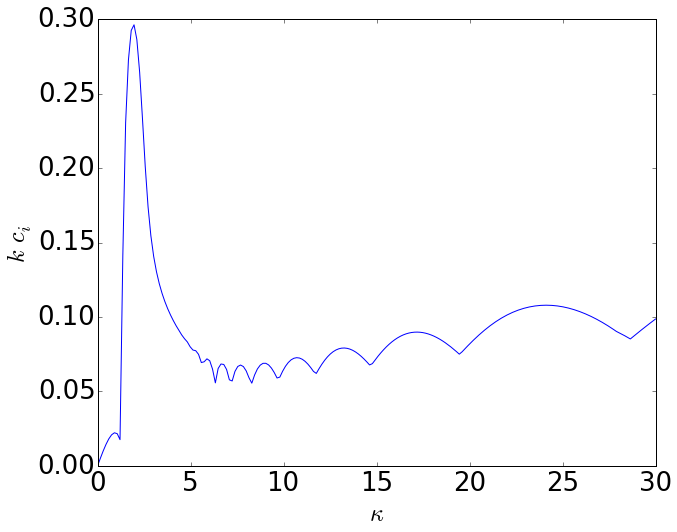

In [8]:
beady30 = np.load('outputs/beta-eady_A_30.npz')

plt.figure(figsize=(10,8))
plt.plot(beady30['kappa'],beady30['sig'][-1,:])
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$k\,c_i$')
plt.savefig('figs/beta-eady_stability_A_ext_kappa')

In [73]:
from sympy import *
from sympy import init_printing
init_printing() 

In [74]:
kappa = symbols('kappa')

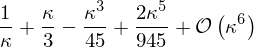

In [75]:
series(coth(kappa),kappa,0)

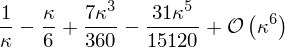

In [76]:
series(1/sinh(kappa),kappa,0)